In [2]:
# all libraries needed
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import Planck13
from tqdm import tqdm
import scipy.ndimage
from astropy.io import fits
import random

2024-10-16 14:42:01.989711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
"""load the dataset"""

# Path to the FITS file
dataset_path = '/Users/mginolfi/Projects/Beta/quasars_spectra_combined.fits'

# Open the FITS file and read the data
with fits.open(dataset_path) as hdu:

    data = hdu[1].data  
    
    # any masking operation can be here
    # data = data[data['REDSHIFT']<2]
    
    # make arrays from spectra and targets
    spectra = data['FLUX']
    loglam = data['LOGLAM']
    dist = data['DIST']
    lo = data['LO']
    lx = data['LX']
    gx = data['GX']
    redshift = data['REDSHIFT']

    # Extract the desired features
    logl1350 = data['LOGL1350']
    logl1700 = data['LOGL1700']
    logl2500 = data['LOGL2500']
    logl3000 = data['LOGL3000']
    logl5100 = data['LOGL5100']
    loglbol = data['LOGLBOL']
    logmbh = data['LOGMBH']
    halpha = data['HALPHA']
    halpha_br = data['HALPHA_BR']
    hbeta = data['HBETA']
    hbeta_br = data['HBETA_BR']
    oiii5007 = data['OIII5007']
    oiii5007c = data['OIII5007C']
    mgii = data['MGII']
    mgii_br = data['MGII_BR']
    civ = data['CIV']

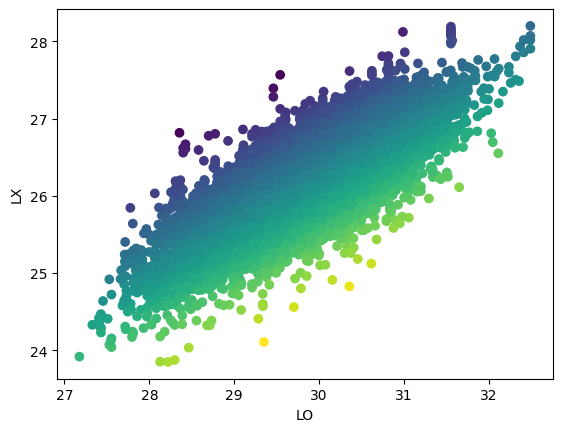

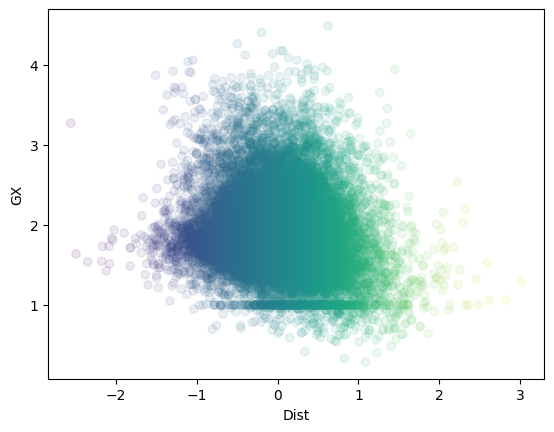

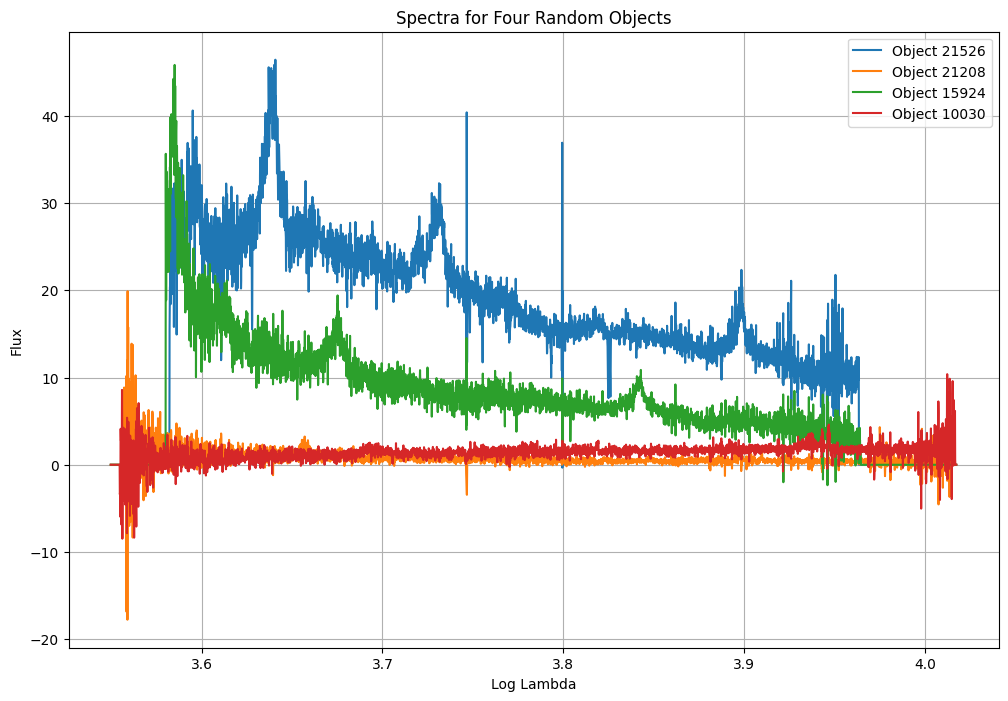

In [4]:
""" Visualize data """

# Visualisation Lo vs Lx

plt.figure()
plt.scatter(lo, lx, c=dist)
plt.xlabel('LO')
plt.ylabel('LX')

# Visualisation gx vs dist

plt.figure()
plt.scatter(dist, gx, c=dist, alpha=0.1)
plt.xlabel('Dist')
plt.ylabel('GX')

# spectra visualisation

random_indices = random.sample(range(spectra.shape[0]), 4)

plt.figure(figsize=(12, 8))

for idx in random_indices:
    plt.plot(loglam[idx], spectra[idx], label=f'Object {idx}')

plt.xlabel('Log Lambda')
plt.ylabel('Flux')
plt.title('Spectra for Four Random Objects')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
""" Make epxeriment """

# chose the target of insterest



# experiment_target = dist.copy()

experiment_target = lx.copy()

In [6]:
X = spectra.copy()
Y = experiment_target.copy()


In [7]:
# normalize X 
# can be done in many ways, pheraps much better ways than this, but just to try..

X = X / X.max()

In [9]:
from sklearn.model_selection import train_test_split


# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp, redshift_train, redshift_temp = train_test_split(
    X, Y, redshift, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test, redshift_val, redshift_test = train_test_split(
    X_temp, y_temp, redshift_temp, test_size=0.5, random_state=42)

In [10]:
# normalise targets

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scaler for X
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_val = scaler_X.transform(X_val)
# X_test = scaler_X.transform(X_test)

# X_train = X_train / X_train.max()
# X_val = X_val / X_train.max()
# X_test = X_test / X_train.max()


# Scaler for y (if y is a continuous target variable)
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# # # Scaler for redshift
scaler_redshift =  MinMaxScaler()
redshift_train = scaler_redshift.fit_transform(redshift_train.reshape(-1, 1)).ravel()
redshift_val = scaler_redshift.transform(redshift_val.reshape(-1, 1)).ravel()
redshift_test = scaler_redshift.transform(redshift_test.reshape(-1, 1)).ravel()


In [11]:
""" MLP """

import tensorflow as tf
from tensorflow.keras.optimizers import Adam


# Spectra input 
spectra_input = tf.keras.Input(shape=(X.shape[1],), name='spectra_input')

# Redshift input
redshift_input = tf.keras.Input(shape=(1,), name='redshift_input')
redshift_layers = tf.keras.layers.Dense(10, activation='selu')(redshift_input)
redshift_layers = tf.keras.layers.Dense(100, activation='selu')(redshift_layers)

# Neural network layers for spectra
spectra_layers = tf.keras.layers.Dense(512, activation='selu')(spectra_input)
spectra_layers = tf.keras.layers.Dense(256, activation='selu')(spectra_layers)
spectra_layers = tf.keras.layers.Dense(128, activation='selu')(spectra_layers)

# Combine spectra and redshift inputs
combined = tf.keras.layers.concatenate([spectra_layers, redshift_layers])

# Continue with more layers as needed
combined_layers = tf.keras.layers.Dense(128, activation='selu')(combined)
combined_layers = tf.keras.layers.Dense(64, activation='selu')(combined_layers)
combined_layers = tf.keras.layers.Dense(32, activation='selu')(combined_layers)


# Output layer for regression
output = tf.keras.layers.Dense(1)(combined_layers)  

# Create the model
model = tf.keras.models.Model(inputs=[spectra_input, redshift_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-10-16 14:45:36.896301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-16 14:45:36.896820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 spectra_input (InputLayer)     [(None, 4676)]       0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 512)          2394624     ['spectra_input[0][0]']          
                                                                                                  
 redshift_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          131328      ['dense_2[0][0]']                
                                                                                              

In [12]:
# Train the model
history = model.fit(
    [X_train, redshift_train], y_train, 
    validation_data=([X_val, redshift_val], y_val), 
    epochs=30, batch_size=1024,
)


Epoch 1/30


2024-10-16 14:45:46.298632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 6s 153ms/step - loss: 0.0419 - val_loss: 0.0191
Epoch 2/30


2024-10-16 14:45:51.257733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 80ms/step - loss: 0.0108 - val_loss: 0.0093
Epoch 3/30
14/14 [==============================] - 1s 98ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 4/30
14/14 [==============================] - 1s 90ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 5/30
14/14 [==============================] - 1s 81ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 6/30
14/14 [==============================] - 1s 87ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 7/30
14/14 [==============================] - 1s 76ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 8/30
14/14 [==============================] - 1s 78ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 9/30
14/14 [==============================] - 1s 83ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 10/30
14/14 [==============================] - 1s 85ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 11/30
14/14 [==============================] - 1s 79ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 12/30
14/14 [

145/145 [==============================] - 1s 9ms/step - loss: 0.0053
Test Loss: 0.0052678026258945465


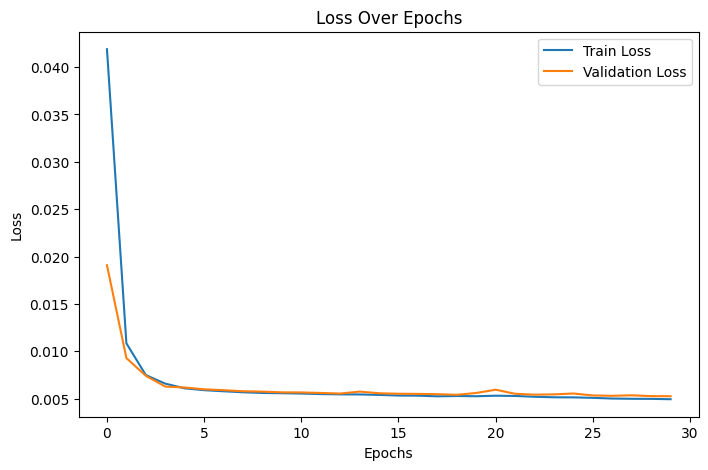

 16/145 [==>...........................] - ETA: 0s

2024-10-16 14:46:39.936679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - 1s 7ms/step


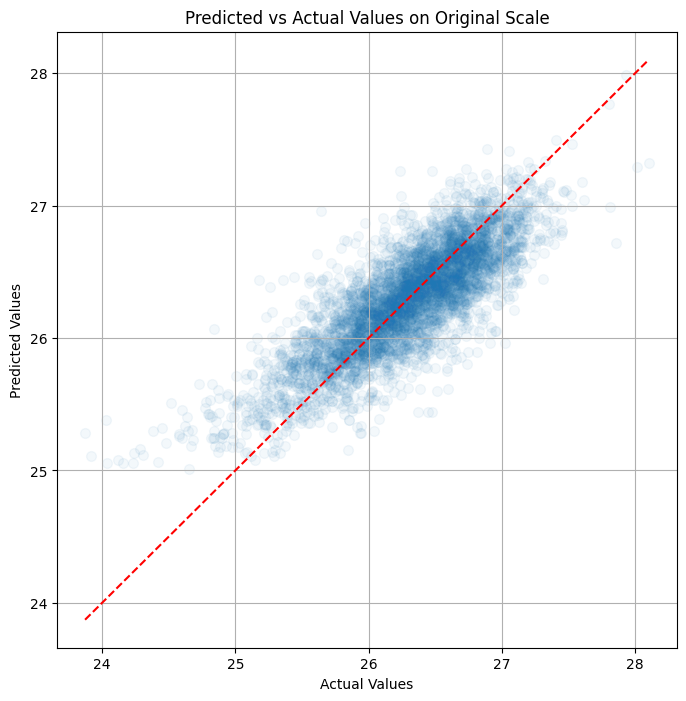

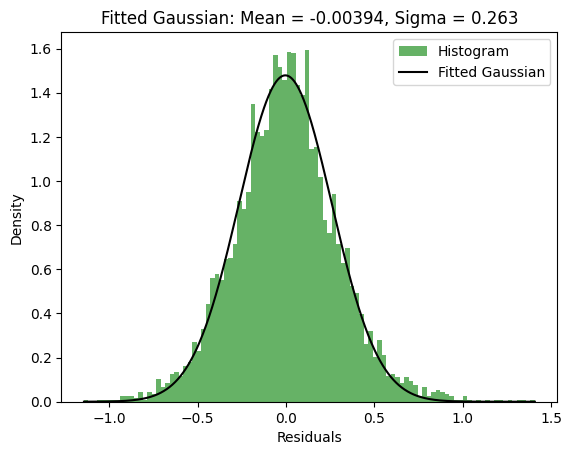

In [13]:
# Evaluate the model
loss = model.evaluate([X_test, redshift_test], y_test)
print(f"Test Loss: {loss}")


import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Predict values
y_pred = model.predict([X_test, redshift_test]).flatten()


# Inverse transform the predictions and actual values
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


# Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original, y_pred_original, alpha=0.05, s=50, )  
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values on Original Scale')
plt.grid(True)
# plt.colorbar()

# Line of perfect prediction
min_val = min(y_test_original.min(), y_pred_original.min())
max_val = max(y_test_original.max(), y_pred_original.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Red dashed line

plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

# Calculate residuals
residuals = y_pred_original - y_test_original


# Create histogram (binned data)
bin_heights, bin_borders, _ = plt.hist(residuals, bins=100, label='Histogram', density=True, alpha=0.6, color='g')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

# Fit the Gaussian to the histogram data
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., max(bin_heights), np.std(residuals)])

# Plot the fitted Gaussian
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Fitted Gaussian', color='black')

# Annotate the plot with the Gaussian parameters
plt.title(f'Fitted Gaussian: Mean = {popt[0]:.5f}, Sigma = {popt[2]:.3f}')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()

# plt.xlim(-0.2, 0.2)

plt.show()

1/1 [==============================] - 0s 25ms/step


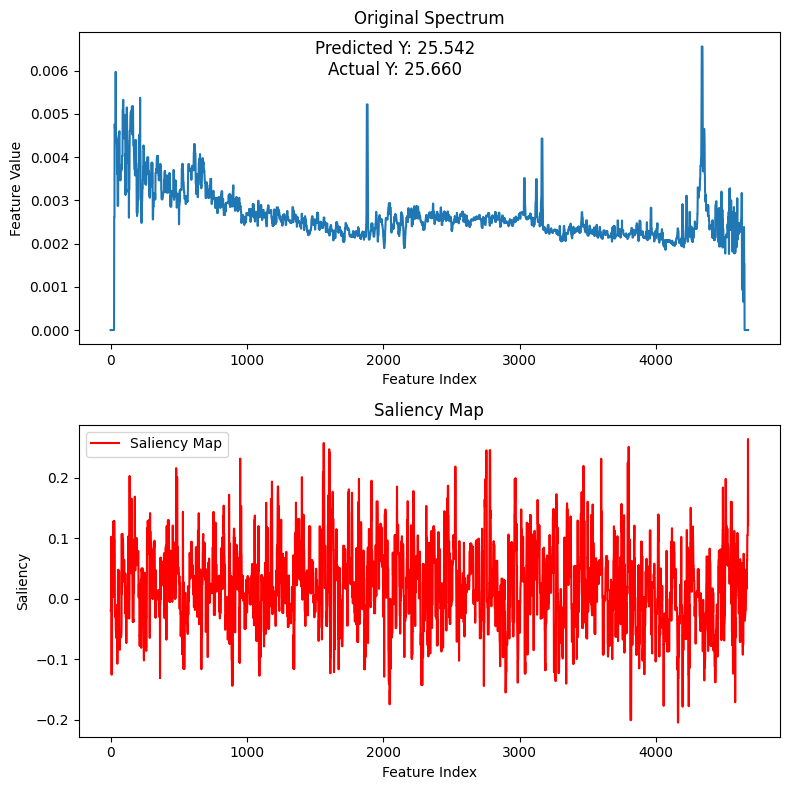

In [22]:
""" Saliency maps """

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random


# Select a random sample from the test set
random_index = random.randint(0, len(X_test) - 1)
sample_X = X_test[random_index]
sample_redshift = redshift_test[random_index]
sample_y = y_test[random_index]

# Convert samples to TensorFlow Tensors
sample_X_tensor = tf.convert_to_tensor(np.expand_dims(sample_X, axis=0), dtype=tf.float32)
sample_redshift_tensor = tf.convert_to_tensor(np.expand_dims(sample_redshift, axis=0), dtype=tf.float32)

# Get the model's prediction
predicted_y = model.predict([sample_X_tensor, sample_redshift_tensor])
predicted_y_original = scaler_y.inverse_transform(predicted_y.reshape(-1, 1)).flatten()[0]

# Compute the saliency map for the spectra input
with tf.GradientTape() as tape:
    tape.watch(sample_X_tensor)
    predictions = model([sample_X_tensor, sample_redshift_tensor])

# Get the gradients of the predictions w.r.t the spectra input
gradients = tape.gradient(predictions, sample_X_tensor).numpy()[0]

# Plot the original spectrum and the saliency map
plt.figure(figsize=(8, 8))

# Original spectrum
plt.subplot(2, 1, 1)
plt.plot(scipy.ndimage.median_filter(sample_X, size=10), label='Original Spectrum')

plt.title('Original Spectrum')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')

# Saliency map
plt.subplot(2, 1, 2)
plt.plot(scipy.ndimage.median_filter(gradients, size=10), label='Saliency Map', color='r')

plt.title('Saliency Map')
plt.xlabel('Feature Index')
plt.ylabel('Saliency')

# Show the plot
plt.tight_layout()
plt.legend()

# Annotate with predicted and actual values
actual_y_original = scaler_y.inverse_transform(np.array([[sample_y]])).flatten()[0]
annotation_text = f"Predicted Y: {predicted_y_original:.3f}\nActual Y: {actual_y_original:.3f}"
plt.gcf().text(0.5, 0.9, annotation_text, ha='center', fontsize=12)

plt.show()